# Reproducing Balaban Exp2 CDA Study (2019) - L vs R
### Notes

In [1]:
import numpy as np
import pandas as pd
import glob
import pickle

import mne
from mne import Epochs, pick_channels, find_events
from mne.io import read_raw_bdf

import sys
sys.path.append('/Users/nick/Documents/PhD/CLCT/reprod/studies/Balaban-2019/')
from events import get_specific_events, get_epochs, get_CDA, prep_report, fill_report, get_report, checksum


import matplotlib.pyplot as plt
%matplotlib inline

## 1. Prep Data

In [2]:
#==================================================================
# General Variables
#==================================================================
# Organize Triggers
triggers = dict();

triggers['2_Integrated'] = [21] 
triggers['4_Integrated'] = [22]
triggers['Separated'] = [23]

triggers['left'] = [32]  #[31]
triggers['right'] = [31] #[32]

triggers['good'] = [50,60]   # YR: Why 2 triggers for good and 2 triggers for bad?!
triggers['bad'] = [5,6]

# Labels
conds = ['2_Integrated', '4_Integrated', 'Separated']
sides = ['left', 'right']
perfs = ['good', 'bad']

# # CDA Channels
chan_right = ['P8', 'PO8', 'PO4']
chan_left = ['P7', 'PO7', 'PO3']

# Epoch Information
epoch_length = 1.7
epoch_tmin = -0.2
baseline_corr = (-0.2, 0)

# # CDA main variable!
cda_dict = dict()
epochs_dict_all = dict()
report = prep_report(conds, sides, perfs)

#==================================================================
# Main Loop - Loading All Files & Extract CDAs.
#==================================================================
folderpath = '/Users/nick/Documents/PhD/CDA Datasets/Balaban 2019/Data/Exp2_EEG/'
#folderpath = 'D:\\CLNT\\Data\\Open Datasets\\Balaban 2019\\Data\\Exp2_EEG\\'
#filepath = folderpath + '536.bdf'
foldersep = '/'

for filepath in glob.iglob(folderpath + '*.bdf'):
    filename = filepath[filepath.rfind(foldersep)+1:]
    print('Processing: ' + filename + '...')

    # ------------------------
    # 1. -- Load File --
    # ------------------------
    raw = read_raw_bdf(filepath, preload=True)
    
    # ------------------------
    # 2. -- Preprocessing --
    # ------------------------
    # Keep only EEG channels and reference
    #raw = raw.rename_channels({'EXG7':'A1', 'EXG8': 'A2'})
    raw = raw.drop_channels(ch_names=['EXG3','EXG4','EXG5','EXG6', 'EXG7','EXG8',])
    raw = raw.set_eeg_reference(ref_channels=['EXG1', 'EXG2'])
    raw = raw.set_channel_types({'EXG1': 'misc', 'EXG2': 'misc'})

    # Set Electrodes Locations
    #montage = mne.channels.make_standard_montage('biosemi32')
    #raw.set_montage(montage)

    preproc = raw

    # Resample
    #preproc = preproc.resample(1024)

    # Filter
    preproc = preproc.filter(.1, 30., fir_design='firwin', skip_by_annotation='edge')

    events = find_events(preproc)
    
    # Chan Pairs
    chan_pairs = ['{}-{}'.format(chan_right[i], chan_left[i]) for i, chan in enumerate(chan_right)]

    for i, chan in enumerate(chan_right):
        preproc = mne.set_bipolar_reference(preproc, anode=[str(chan_right[i])], cathode=[str(chan_left[i])])
        #new_cda = cur_bipolar_epochs.pick_channels(['{}-{}'.format(chan_right[i], chan_left[i])]).average().data

    preproc = preproc.pick_channels(chan_pairs)
    
    #preproc.plot(events=events, block=True, lowpass=40)
    
    # ------------------------
    # 3. -- Epochs --
    # ------------------------
    # Get events based on conditions, sides (L/R) and performances
    # Code available in events.py
    specific_events = get_specific_events(events, conds, sides, perfs, triggers)

    epochs_dict = get_epochs(preproc, specific_events, epoch_length, epoch_tmin, baseline_corr)

    epochs_dict_all[filename] = epochs_dict
        
    # ------------------------
    # 4. - Report & Checksum -
    # ------------------------
    #report = fill_report(report, filename, specific_events)
    #report.at[filename, 'checksum'] = checksum(specific_events, epochs_dict)
    
    # ------------------------
    # 5. -- CDA --
    # ------------------------
    #cda_dict[filename] = get_CDA(epochs_dict, conds, sides, perfs, chan_right, chan_left)

# Add time points to CDA for later use.
cda_dict['times'] = epochs_dict['2_Integrated']['left']['good'].times

print('{} Subjects & {} Trials'.format(len(report), np.sum([report[cond].sum() for cond in conds])))
report

Processing: 514.bdf...
Extracting EDF parameters from /Users/nick/Documents/PhD/CDA Datasets/Balaban 2019/Data/Exp2_EEG/514.bdf...
BDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 936703  =      0.000 ...  3658.996 secs...
EEG channel type selected for re-referencing
Applying a custom ('EEG',) reference.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.10
- Lower transition bandwidth: 0.10 Hz (-6 dB cutoff frequency: 0.05 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 8449 samples (33.004 sec)

Trigger channel has a non-zero initial value of 65536 (consider using initial_ev

0 bad epochs dropped
---------- 2_Integrated-left-bad -------------
Not setting metadata
Not setting metadata
14 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Loading data for 14 events and 487 original time points ...
0 bad epochs dropped
---------- 2_Integrated-right-good -------------
Not setting metadata
Not setting metadata
104 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Loading data for 104 events and 487 original time points ...
0 bad epochs dropped
---------- 2_Integrated-right-bad -------------
Not setting metadata
Not setting metadata
15 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Loading data for 15 events and 487 original time points ...
0 bad epochs dropped
---------- 4_Integrated-left-good -------------
Not setting metadata
Not setting metadata
80 matching events found
Applying baseline correction (mode: mean)
0 projection items 

Loading data for 73 events and 487 original time points ...
0 bad epochs dropped
---------- Separated-right-bad -------------
Not setting metadata
Not setting metadata
18 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Loading data for 18 events and 487 original time points ...
0 bad epochs dropped
====================== /EPOCHING ======================
Processing: 517.bdf...
Extracting EDF parameters from /Users/nick/Documents/PhD/CDA Datasets/Balaban 2019/Data/Exp2_EEG/517.bdf...
BDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 861695  =      0.000 ...  3365.996 secs...
EEG channel type selected for re-referencing
Applying a custom ('EEG',) reference.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Ha

    Range : 0 ... 870911 =      0.000 ...  3401.996 secs
Ready.
Added the following bipolar channels:
PO4-PO3
====================== EPOCHING ======================
tmin:-0.2, tmax:1.7, baseline=(-0.2, 0)
---------- 2_Integrated-left-good -------------
Not setting metadata
Not setting metadata
94 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Loading data for 94 events and 487 original time points ...
0 bad epochs dropped
---------- 2_Integrated-left-bad -------------
Not setting metadata
Not setting metadata
21 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Loading data for 21 events and 487 original time points ...
0 bad epochs dropped
---------- 2_Integrated-right-good -------------
Not setting metadata
Not setting metadata
109 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Loading data for 109 events and 487 original time points ...
0 bad epochs 

---------- Separated-left-bad -------------
Not setting metadata
Not setting metadata
35 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Loading data for 35 events and 487 original time points ...
0 bad epochs dropped
---------- Separated-right-good -------------
Not setting metadata
Not setting metadata
96 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Loading data for 96 events and 487 original time points ...
0 bad epochs dropped
---------- Separated-right-bad -------------
Not setting metadata
Not setting metadata
21 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Loading data for 21 events and 487 original time points ...
0 bad epochs dropped
====================== /EPOCHING ======================
Processing: 516.bdf...
Extracting EDF parameters from /Users/nick/Documents/PhD/CDA Datasets/Balaban 2019/Data/Exp2_EEG/516.bdf...
BDF file detected
Set

Ready.
Added the following bipolar channels:
P8-P7
EEG channel type selected for re-referencing
Creating RawArray with float64 data, n_channels=1, n_times=983552
    Range : 0 ... 983551 =      0.000 ...  3841.996 secs
Ready.
Added the following bipolar channels:
PO8-PO7
EEG channel type selected for re-referencing
Creating RawArray with float64 data, n_channels=1, n_times=983552
    Range : 0 ... 983551 =      0.000 ...  3841.996 secs
Ready.
Added the following bipolar channels:
PO4-PO3
====================== EPOCHING ======================
tmin:-0.2, tmax:1.7, baseline=(-0.2, 0)
---------- 2_Integrated-left-good -------------
Not setting metadata
Not setting metadata
92 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Loading data for 92 events and 487 original time points ...
0 bad epochs dropped
---------- 2_Integrated-left-bad -------------
Not setting metadata
Not setting metadata
22 matching events found
Applying baseline correction (m

0 projection items activated
Loading data for 25 events and 487 original time points ...
0 bad epochs dropped
---------- Separated-left-good -------------
Not setting metadata
Not setting metadata
101 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Loading data for 101 events and 487 original time points ...
0 bad epochs dropped
---------- Separated-left-bad -------------
Not setting metadata
Not setting metadata
12 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Loading data for 12 events and 487 original time points ...
0 bad epochs dropped
---------- Separated-right-good -------------
Not setting metadata
Not setting metadata
81 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Loading data for 81 events and 487 original time points ...
0 bad epochs dropped
---------- Separated-right-bad -------------
Not setting metadata
Not setting metadata
21 matchi

EEG channel type selected for re-referencing
Creating RawArray with float64 data, n_channels=1, n_times=938496
    Range : 0 ... 938495 =      0.000 ...  3665.996 secs
Ready.
Added the following bipolar channels:
P8-P7
EEG channel type selected for re-referencing
Creating RawArray with float64 data, n_channels=1, n_times=938496
    Range : 0 ... 938495 =      0.000 ...  3665.996 secs
Ready.
Added the following bipolar channels:
PO8-PO7
EEG channel type selected for re-referencing
Creating RawArray with float64 data, n_channels=1, n_times=938496
    Range : 0 ... 938495 =      0.000 ...  3665.996 secs
Ready.
Added the following bipolar channels:
PO4-PO3
====================== EPOCHING ======================
tmin:-0.2, tmax:1.7, baseline=(-0.2, 0)
---------- 2_Integrated-left-good -------------
Not setting metadata
Not setting metadata
110 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Loading data for 110 events and 487 original time points 

0 bad epochs dropped
---------- 4_Integrated-right-bad -------------
Not setting metadata
Not setting metadata
38 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Loading data for 38 events and 487 original time points ...
0 bad epochs dropped
---------- Separated-left-good -------------
Not setting metadata
Not setting metadata
82 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Loading data for 82 events and 487 original time points ...
0 bad epochs dropped
---------- Separated-left-bad -------------
Not setting metadata
Not setting metadata
24 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Loading data for 24 events and 487 original time points ...
0 bad epochs dropped
---------- Separated-right-good -------------
Not setting metadata
Not setting metadata
113 matching events found
Applying baseline correction (mode: mean)
0 projection items activated


EEG channel type selected for re-referencing
Creating RawArray with float64 data, n_channels=1, n_times=746752
    Range : 0 ... 746751 =      0.000 ...  2916.996 secs
Ready.
Added the following bipolar channels:
P8-P7
EEG channel type selected for re-referencing
Creating RawArray with float64 data, n_channels=1, n_times=746752
    Range : 0 ... 746751 =      0.000 ...  2916.996 secs
Ready.
Added the following bipolar channels:
PO8-PO7
EEG channel type selected for re-referencing
Creating RawArray with float64 data, n_channels=1, n_times=746752
    Range : 0 ... 746751 =      0.000 ...  2916.996 secs
Ready.
Added the following bipolar channels:
PO4-PO3
====================== EPOCHING ======================
tmin:-0.2, tmax:1.7, baseline=(-0.2, 0)
---------- 2_Integrated-left-good -------------
Not setting metadata
Not setting metadata
86 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Loading data for 86 events and 487 original time points ..

0 bad epochs dropped
---------- 4_Integrated-right-bad -------------
Not setting metadata
Not setting metadata
38 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Loading data for 38 events and 487 original time points ...
0 bad epochs dropped
---------- Separated-left-good -------------
Not setting metadata
Not setting metadata
94 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Loading data for 94 events and 487 original time points ...
0 bad epochs dropped
---------- Separated-left-bad -------------
Not setting metadata
Not setting metadata
15 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Loading data for 15 events and 487 original time points ...
0 bad epochs dropped
---------- Separated-right-good -------------
Not setting metadata
Not setting metadata
99 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
L

,2_Integrated,4_Integrated,Separated,left,right,good,bad,2_Integrated-left,2_Integrated-left-good,2_Integrated-good,...,Separated-left,Separated-left-good,Separated-good,Separated-left-bad,Separated-bad,Separated-right,Separated-right-good,Separated-right-bad,checksum,notes


In [3]:
times = cda_dict['times']
del cda_dict['times']

## 2. Save CDA Data

In [5]:
# ------------------------
# Save the whole CDA dict.
# ------------------------
with open("cda_balaban2019_exp2_raw.pkl","wb") as f:
    pickle.dump(cda_dict, f)

## 3. Load CDA Data

In [6]:
with open("cda_balaban2019_exp2_raw.pkl","rb") as f:
    cda_dict = pickle.load(f)

times = cda_dict['times']
del cda_dict['times']

len(cda_dict)

16

## 4. Plot CDA Data - Grand CDA Average

In [4]:
cda_all = dict()

for cond in epochs_dict_all[list(epochs_dict_all.keys())[0]].keys():
    cda_all[cond] = dict()
    cda_all[cond]['left'] = np.array([])
    cda_all[cond]['right'] = np.array([])

    for f in epochs_dict_all.keys():        
        perf = 'good'
        
        ldata = epochs_dict_all[f][cond]['left'][perf].average().data.mean(0)
        rdata = epochs_dict_all[f][cond]['right'][perf].average().data.mean(0)
                   
        cda_all[cond]['left'] = np.vstack([cda_all[cond]['left'], ldata]) if len(cda_all[cond]['left']) else ldata
        cda_all[cond]['right'] = np.vstack([cda_all[cond]['right'], rdata]) if len(cda_all[cond]['right']) else rdata

Text(0.5, 0, '[s]')

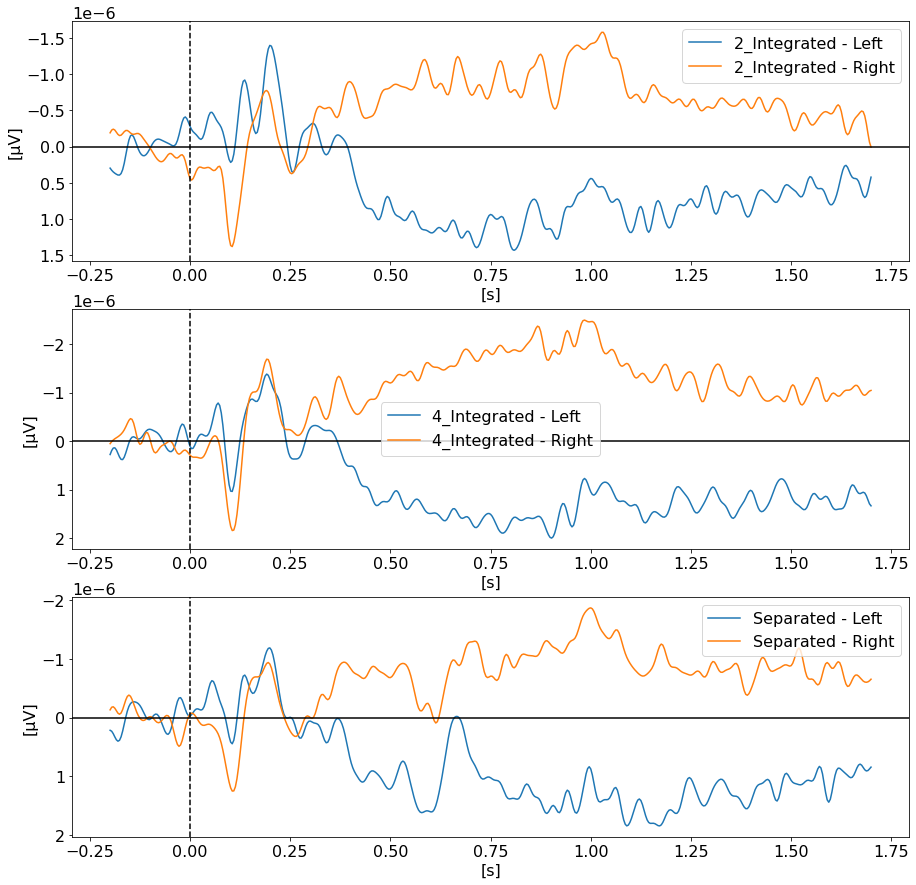

In [5]:
plt.rcParams.update({'font.size': 16})

fig, axs = plt.subplots(3, 1, figsize=(15,15))

# 2. Plot Figure #1
axs[0].plot(times, cda_all['2_Integrated']['left'].mean(0), label='2_Integrated - Left')
axs[0].plot(times, cda_all['2_Integrated']['right'].mean(0), label='2_Integrated - Right')
axs[0].axvline(x=0, color='k', linestyle='--')
axs[0].axhline(y=0, color='k', linestyle='-')
axs[0].invert_yaxis()
axs[0].legend()
axs[0].set_ylabel('[μV]')
axs[0].set_xlabel('[s]')

# 2. Plot Figure #2
axs[1].plot(times, cda_all['4_Integrated']['left'].mean(0), label='4_Integrated - Left')
axs[1].plot(times, cda_all['4_Integrated']['right'].mean(0), label='4_Integrated - Right')
axs[1].axvline(x=0, color='k', linestyle='--')
axs[1].axhline(y=0, color='k', linestyle='-')
axs[1].invert_yaxis()
axs[1].legend()
axs[1].set_ylabel('[μV]')
axs[1].set_xlabel('[s]')

# 2. Plot Figure #3
axs[2].plot(times, cda_all['Separated']['left'].mean(0), label='Separated - Left')
axs[2].plot(times, cda_all['Separated']['right'].mean(0), label='Separated - Right')
axs[2].axvline(x=0, color='k', linestyle='--')
axs[2].axhline(y=0, color='k', linestyle='-')
axs[2].invert_yaxis()
axs[2].legend()
axs[2].set_ylabel('[μV]')
axs[2].set_xlabel('[s]')

#plt.savefig("./V-2018-Exp1_CDA-reprod.png", dpi=300, format='png')